In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib.colors import ListedColormap
import plotly.graph_objs as go

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from skorch import NeuralNetRegressor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
import joblib

sns.set(style='whitegrid')

In [6]:
# Load the dataset
df = pd.read_csv('Datasets/direct1.csv')
print("First few rows of the dataset:")
df.head()

First few rows of the dataset:


,Reference,Rock,P’[MPa],Permeability [nD],Porosity [%],Breakthrough pressure [MPa]
0,Amann-Hildenbrand et al. 2013,Opalinus Clay,25.0,6.9,11.6,4.1
1,Amann-Hildenbrand et al. 2013,Opalinus Clay,25.0,2.0,13.0,17.5
2,Amann-Hildenbrand et al. 2013,Opalinus Clay,25.0,2.5,13.0,14.0
3,Boulin et al. 2013,Ketzin Claystone,7.0,31.8,15.0,10.4
4,Boulin et al. 2013,Ketzin Claystone,25.0,15.6,15.0,13.0


In [7]:
df.shape

(63, 6)

In [8]:
# Load the dataset
df1 = pd.read_csv('Datasets/direct2.csv')
print("First few rows of the dataset:")
df1.head()

First few rows of the dataset:


,Reference,Rock,P’[MPa],Permeability [nD],Porosity [%],SSA [m2g-1],Pore diameter [nm],Clay content [%],Breakthrough pressure [MPa]
0,Amann-Hildenbrand 2013,Opalinus Clay,25.0,6.9,11.6,39.0,14.0,60.0,4.1
1,Amann-Hildenbrand et al. 2015,Opalinus Clay,25.0,2.0,13.0,NaN,10.0,80.0,17.5
2,Amann-Hildenbrand et al. 2015,Opalinus Clay,25.0,2.5,13.0,NaN,10.0,80.0,14.0
3,Hildenbrand et al. 2004,Boom Clay,20.0,557.0,24.4,20.1,170.0,3.0,5.8
4,Hildenbrand et al. 2004,Boom Clay,20.0,24.3,23.5,23.6,55.0,40.0,6.0


# Prediction of Breakthrough Pressure with 2 Variables: Direct Tests

## Data Preprocessing

In [19]:
df.columns

Index(['Reference', 'Rock', 'P’[MPa]', 'Permeability [nD]', 'Porosity [%]',
       'BP [MPa]'],
      dtype='object')

In [20]:
feature_columns = ['P’[MPa]','Permeability [nD]', 'Porosity [%]']
target_column= 'BP [MPa]'

In [21]:
# Encoding
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

df.columns

Index(['Reference', 'Rock', 'P’[MPa]', 'Permeability [nD]', 'Porosity [%]',
       'BP [MPa]'],
      dtype='object')

In [22]:
# Replace special symbols in column names
df = df.rename(columns={"P’[MPa]": "P1", "Permeability [nD]": "P2", 
                        'Porosity [%]': 'P3', 'BP [MPa]':'Target'})
df.columns = df.columns.str.replace('[^A-Za-z0-9]+', '_')
print(df.columns)

Index(['Reference', 'Rock', 'P1', 'P2', 'P3', 'Target'], dtype='object')


In [23]:
feature_columns = ['P1', 'P2', 'P3']
target_column= 'Target'

In [24]:
X = df[feature_columns]
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
X_train.shape

(50, 3)

In [26]:
X_test.shape

(13, 3)

## Model Building


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.7}
Mean Squared Error (MSE): 9.507762424158155
Mean Absolute Error (MAE): 2.054512728544382
R-squared (R2): 0.2397785316882327


/var/folders/xp/jy5j7tmd2c7bsktzm4pdpxm40000gn/T/ipykernel_41218/3254981986.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')


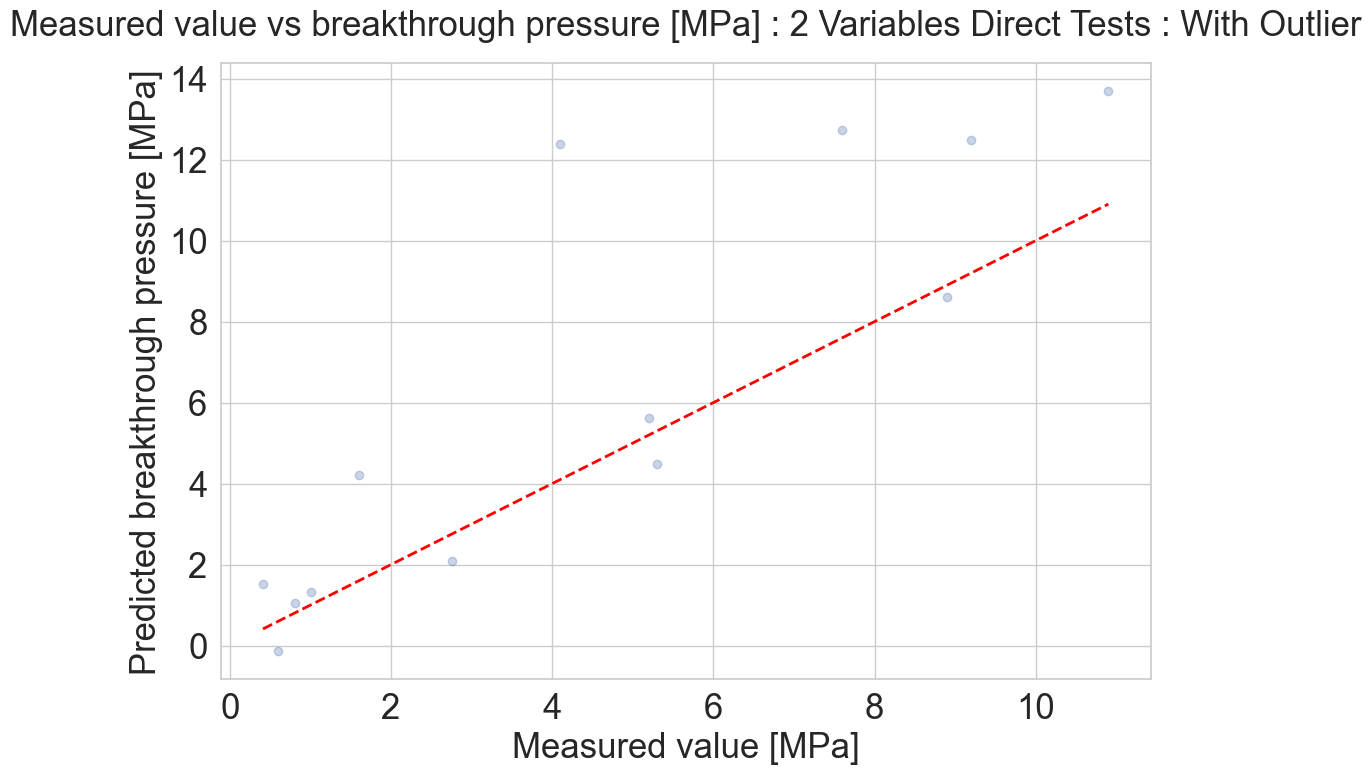

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

model = xgb.XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')
plt.xlabel('Measured value [MPa]', fontsize=25, fontname='Arial')
plt.ylabel('Predicted breakthrough pressure [MPa]', fontsize=25, fontname='Arial')
plt.title('Measured value vs breakthrough pressure [MPa] : 2 Variables Direct Tests : With Outlier', fontsize=25, fontname='Arial', pad=20)
plt.xticks(fontsize=25, fontname='Arial')
plt.yticks(fontsize=25, fontname='Arial')
plt.show()

In [29]:
df[df['P2']>10000]

,Reference,Rock,P1,P2,P3,Target
54,3,3,NaN,44000.0,17.0,0.31
55,3,3,NaN,16000.0,14.5,0.60


In [30]:
df = df[df['P2']<10000]

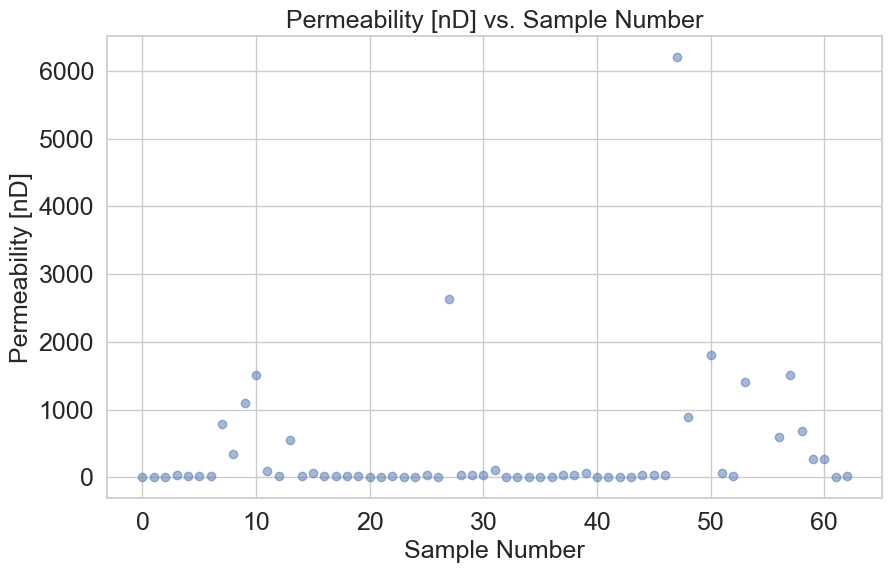

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['P2'], alpha=0.5)
plt.xlabel('Sample Number', fontsize=18, fontname='Arial')
plt.ylabel('Permeability [nD]', fontsize=18, fontname='Arial')
plt.title('Permeability [nD] vs. Sample Number', fontsize=18, fontname='Arial')
plt.xticks(fontsize=18, fontname='Arial')
plt.yticks(fontsize=18, fontname='Arial')
plt.show()


In [34]:
X = df[feature_columns]
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
X_train.shape

(48, 3)

In [36]:
X_test.shape

(12, 3)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Mean Squared Error (MSE): 39.03045370854596
Mean Absolute Error (MAE): 3.6076805496215822
R-squared (R2): 0.27606806945645257


/var/folders/xp/jy5j7tmd2c7bsktzm4pdpxm40000gn/T/ipykernel_41218/1181432351.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')


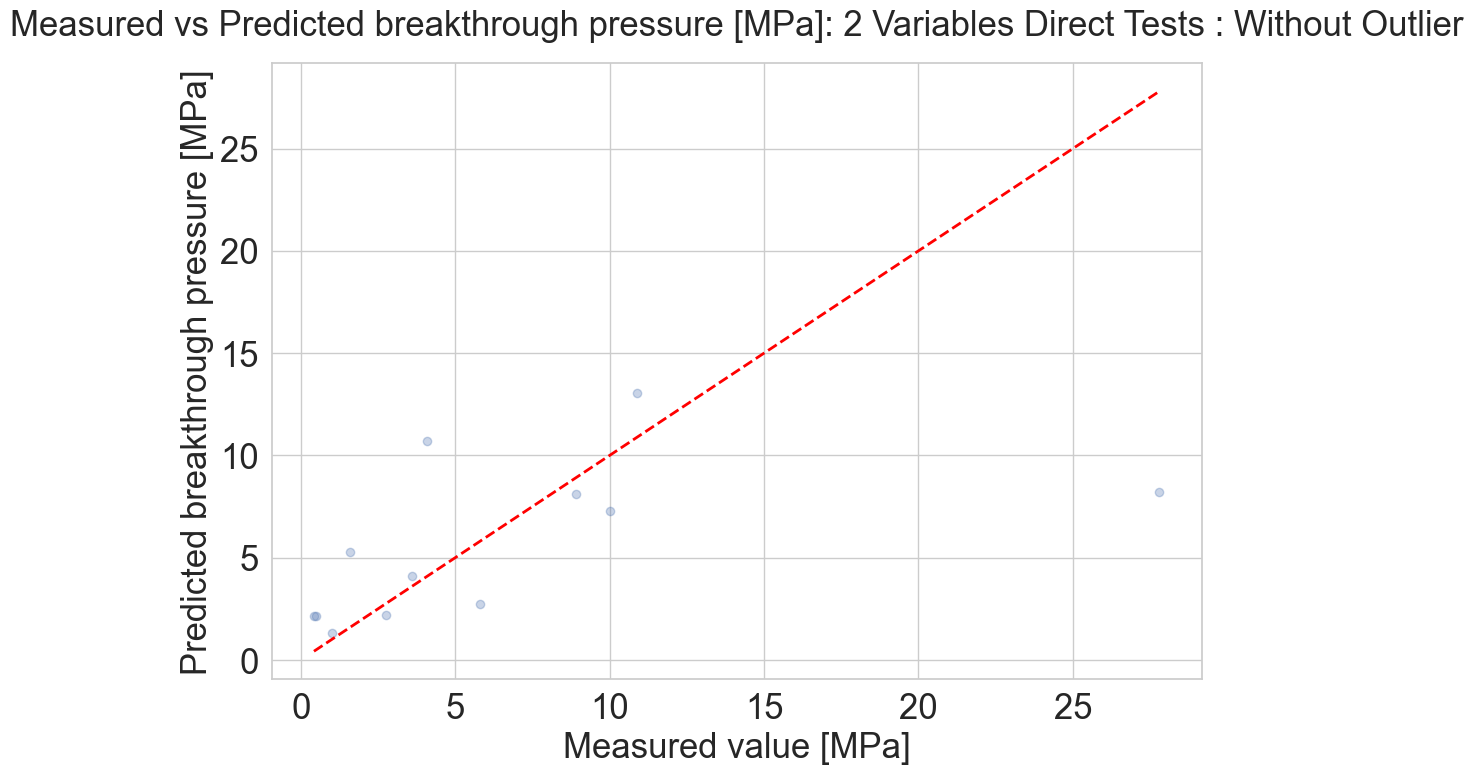

In [37]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

model = xgb.XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Plot the results
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')
plt.xlabel('Measured value [MPa]', fontsize=25)
plt.ylabel('Predicted breakthrough pressure [MPa]', fontsize=25)
plt.title('Measured vs Predicted breakthrough pressure [MPa]: 2 Variables Direct Tests : Without Outlier', fontsize=25, pad=20)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

# Prediction of Breakthrough Pressure with 5 Variables: Direct Tests

## Exploratory Data Analysis

In [38]:
df1.columns

Index(['Reference', 'Rock', 'P’[MPa]', 'Permeability [nD]', 'Porosity [%]',
       'SSA [m2g-1]', 'Pore diameter [nm]', 'Clay content [%]',
       'Breakthrough pressure [MPa]'],
      dtype='object')

## Data Preprocessing

In [48]:
df1.columns

Index(['Reference', 'Rock', 'P’[MPa]', 'Permeability [nD]', 'Porosity [%]',
       'SSA [m2g-1]', 'Pore diameter [nm]', 'Clay content [%]', 'BP [MPa]'],
      dtype='object')

In [49]:
feature_columns = [
       'Permeability [nD]', 'Porosity [%]', 'SSA [m2g-1]',
       'Pore diameter [nm]', 'Clay content [%]']
target_column= 'BP [MPa]'

In [50]:
# Encoding
label_encoders = {}
for column in df1.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    df1[column] = label_encoders[column].fit_transform(df1[column])
df1.columns

Index(['Reference', 'Rock', 'P’[MPa]', 'Permeability [nD]', 'Porosity [%]',
       'SSA [m2g-1]', 'Pore diameter [nm]', 'Clay content [%]', 'BP [MPa]'],
      dtype='object')

In [51]:
# Replace special symbols in column names
df1 = df1.rename(columns={"P’[MPa]": "P1", "Permeability [nD]": "P2", 
                        'Porosity [%]': 'P3','Pore diameter [nm]': 'P4',
                          'Clay content [%]': 'P5', 'SSA [m2g-1]': 'P6','BP [MPa]':'Target'})
df1.columns = df1.columns.str.replace('[^A-Za-z0-9]+', '_')
print(df1.columns)

Index(['Reference', 'Rock', 'P1', 'P2', 'P3', 'P6', 'P4', 'P5', 'Target'], dtype='object')


In [52]:
feature_columns = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6']
target_column= 'Target'
X = df1[feature_columns]
y = df1[target_column]

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape

(28, 6)

In [54]:
X_test.shape

(8, 6)

## Model Building

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.7}
Mean Squared Error (MSE): 1.4037250694476213
Mean Absolute Error (MAE): 1.0191778671741485
R-squared (R2): 0.8317390567206255


/var/folders/xp/jy5j7tmd2c7bsktzm4pdpxm40000gn/T/ipykernel_41218/453503547.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')


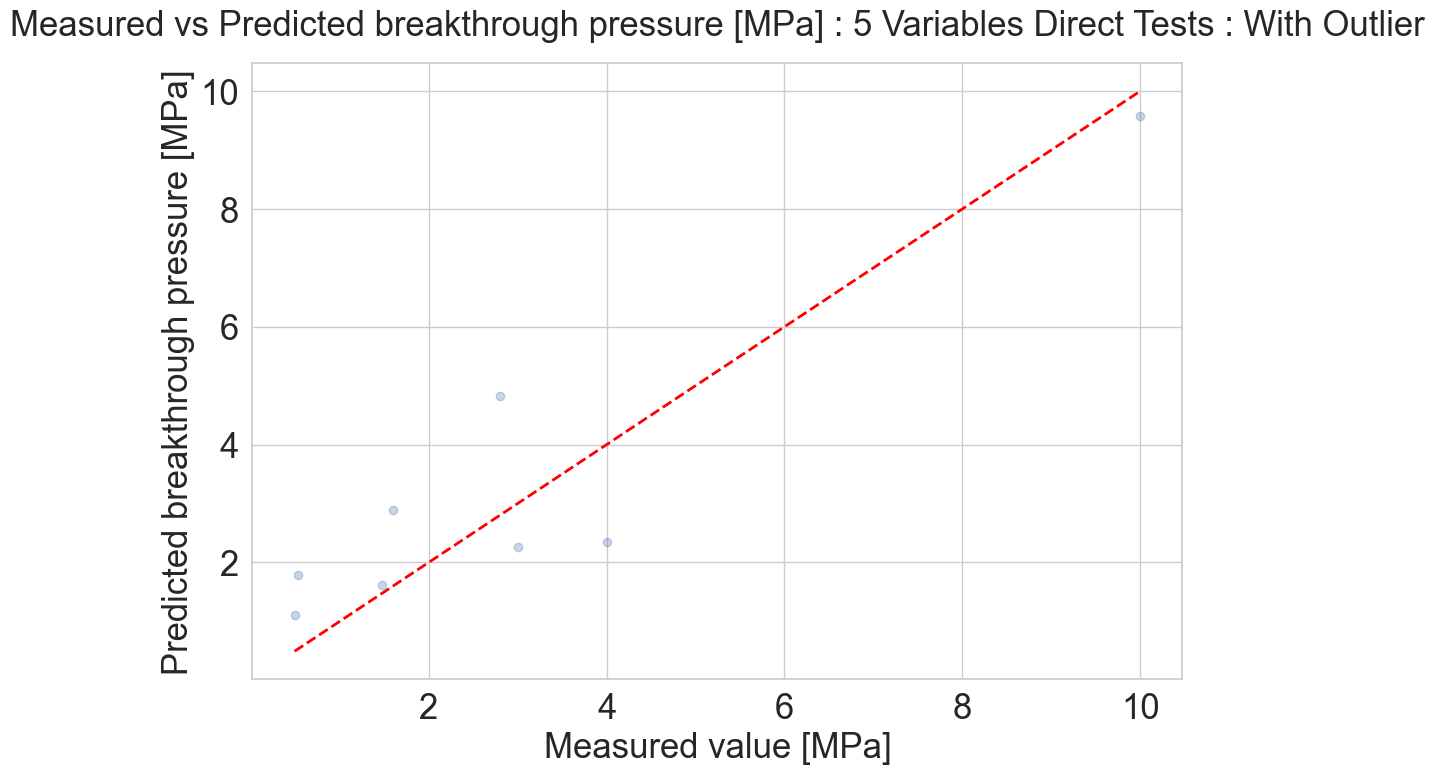

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Initialize XGBRegressor model
model = xgb.XGBRegressor(objective='reg:squarederror')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Plot the results
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')
plt.xlabel('Measured value [MPa]', fontsize=25, fontname='Arial')
plt.ylabel('Predicted breakthrough pressure [MPa]', fontsize=25, fontname='Arial')
plt.title('Measured vs Predicted breakthrough pressure [MPa] : 5 Variables Direct Tests : With Outlier', fontsize=25, fontname='Arial', pad=20)
plt.xticks(fontsize=25, fontname='Arial')
plt.yticks(fontsize=25, fontname='Arial')
plt.show()

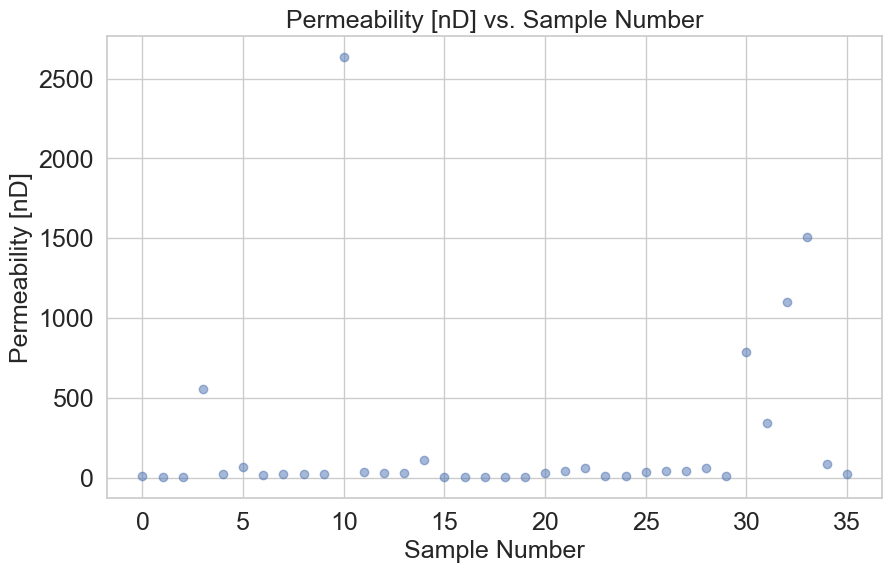

In [56]:
plt.figure(figsize=(10, 6))
plt.scatter(df1.index, df1['P2'], alpha=0.5)
plt.xlabel('Sample Number', fontsize=18)
plt.ylabel('Permeability [nD]', fontsize=18)
plt.title('Permeability [nD] vs. Sample Number', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [57]:
df1 = df1[df1['P2']<10000]

In [58]:
feature_columns = ['P1', 'P2', 'P3', 'P4', 'P5']
target_column= 'Target'

In [59]:
X = df1[feature_columns]
y = df1[target_column]

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape

(28, 5)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Mean Squared Error (MSE): 1.212273744496226
Mean Absolute Error (MAE): 0.9074617311358452
R-squared (R2): 0.8546878386648593


/var/folders/xp/jy5j7tmd2c7bsktzm4pdpxm40000gn/T/ipykernel_41218/2223910562.py:39: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')


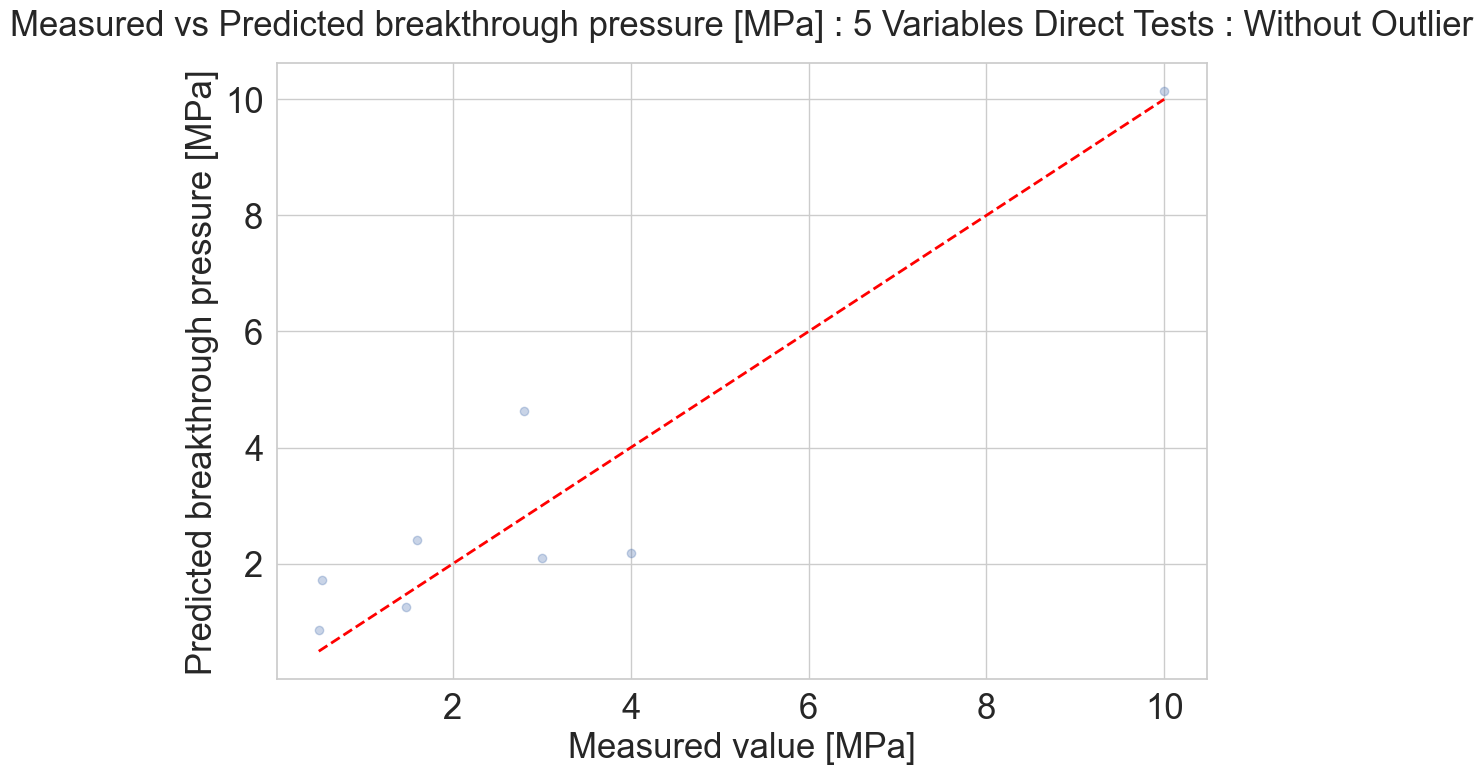

In [61]:
# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Initialize XGBRegressor model
model = xgb.XGBRegressor(objective='reg:squarederror')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Plot the results
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')
plt.xlabel('Measured value [MPa]', fontsize=25, fontname='Arial')
plt.ylabel('Predicted breakthrough pressure [MPa]', fontsize=25, fontname='Arial')
plt.title('Measured vs Predicted breakthrough pressure [MPa] : 5 Variables Direct Tests : Without Outlier', fontsize=25, fontname='Arial', pad=20)
plt.xticks(fontsize=25, fontname='Arial')
plt.yticks(fontsize=25, fontname='Arial')
plt.show()

In [62]:
df.columns

Index(['Reference', 'Rock', 'P1', 'P2', 'P3', 'Target'], dtype='object')